# Урок: Сверточные нейронные сети

## Задание: 

* реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
* оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
* оценить рост точности при увеличении глубины сети (больше слоев)

In [10]:
import os
import matplotlib.pyplot as plt

# from __future__ import print_function

import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [11]:
def plot(train_loss, test_loss, title):
  plt.figure(figsize=(20,5))
  plt.plot(train_loss, label = 'train loss')
  plt.plot(test_loss, label = 'test loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.grid('On')
  plt.title(title)
  plt.show()

In [12]:
num_classes = 10

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


## Базовый вариант сети

### Конфигурация

In [13]:
model_1 = Sequential()

# слои свертки и max-pooling #1
model_1.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# слои свертки и max-pooling #2
model_1.add(Conv2D(64, (3, 3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# полносвязный слой
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

# компиляция модели
model_1.compile(
  loss='categorical_crossentropy',
  optimizer='SGD',
  metrics=['accuracy'],
)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

### Обучение

Epoch 1/5
1563/1563 [==============================] - 39s 5ms/step - loss: 2.0868 - accuracy: 0.2243 - val_loss: 1.7912 - val_accuracy: 0.3551
Epoch 2/5
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7648 - accuracy: 0.3546 - val_loss: 1.8268 - val_accuracy: 0.3451
Epoch 3/5
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6181 - accuracy: 0.4110 - val_loss: 1.5077 - val_accuracy: 0.4494
Epoch 4/5
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5196 - accuracy: 0.4469 - val_loss: 1.3826 - val_accuracy: 0.4987
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.3097 - accuracy: 0.5281


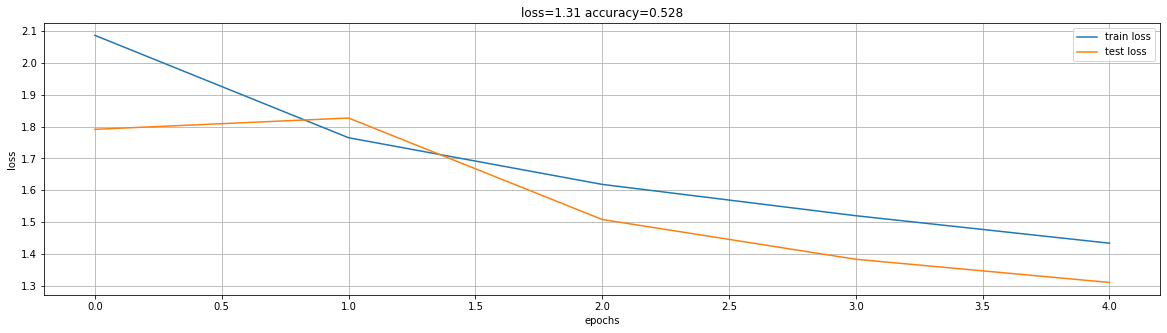

In [14]:
hh = model_1.fit(
  x_train,
  y_train,
  batch_size=32,
  epochs=5,
  validation_data=(x_test, y_test),
  shuffle=True,
)

# проверка работы обученной модели
result = model_1.evaluate(
  x_test,
  y_test,
  verbose=1,
)

plot(hh.history['loss'], hh.history['val_loss'], f'loss={round(result[0], 3)} accuracy={round(result[1], 3)}')

## Оптимизированный вариант сети

### Конфигурация

In [15]:
# конфигурирование слоев нейросети
model_2 = Sequential()

# слои свертки и max-pooling #1
model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

# слои свертки и max-pooling #2
model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())

# полносвязный слой #1
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

# полносвязный слой #2
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

# компиляция модели
model_2.compile(
  loss='categorical_crossentropy',
  optimizer='nadam',
  metrics=['accuracy']
)

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7290 - accuracy: 0.7542 - val_loss: 0.6335 - val_accuracy: 0.7895
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7128 - accuracy: 0.7598 - val_loss: 0.6489 - val_accuracy: 0.7763
Epoch 3/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6953 - accuracy: 0.7651 - val_loss: 0.6390 - val_accuracy: 0.7867
Epoch 4/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6835 - accuracy: 0.7686 - val_loss: 0.6395 - val_accuracy: 0.7881
Epoch 5/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6650 - accuracy: 0.7768 - val_loss: 0.6772 - val_accuracy: 0.7686
Epoch 6/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6678 - accuracy: 0.7750 - val_loss: 0.6000 - val_accuracy: 0.7975
Epoch 7/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6476 - accuracy: 0.7824 - val_loss: 0.6183 - val_ac

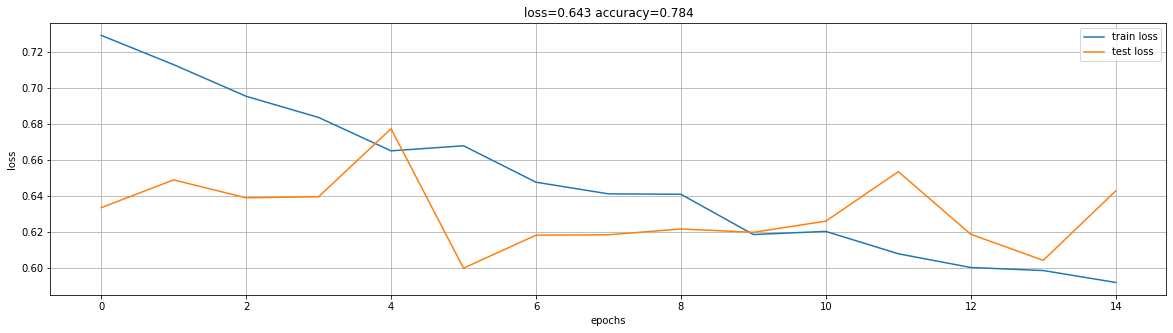

In [18]:
hh = model_2.fit(
  x_train,
  y_train,
  batch_size=32,
  epochs=15,
  validation_data=(x_test, y_test),
  shuffle=True,
)

# проверка работы обученной модели
result = model_2.evaluate(
  x_test,
  y_test,
  verbose=1
)

plot(hh.history['loss'], hh.history['val_loss'], f'loss={round(result[0], 3)} accuracy={round(result[1], 3)}')

## Вывод

Базовый вариант сети:
* 2 слоя свертки + max-pooling
* 1 полносвязный слой 512 нейронов
* оптимизатор SGD
* 5 эпох

accuracy: 0.5281

----

Оптимизированный вариант сети:
* 2 слоя свертки + max-pooling
* 2 полносвязных слоя по 512 нейронов
* оптимизатор Nadam
* 20 эпох

accuracy: 0.7843